Empezamos haciendo los imports necesarios y definiendo el dataframe

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv("diabetes_prediction_dataset.csv")

Transformamos los valores redundantes y los combinamos para una mayor claridad

In [ ]:
def agruparValoresRedundatesFumadores(valor):
    valor = valor.lower()
    if valor in ['never']:
        return 'never'
    elif valor in ['former', 'not current', 'ever']:
        return 'not_current'
    elif valor in ['current']:
        return 'current'
    else:
        return 'unknown'

df['smoking_history'] = df['smoking_history'].apply(agruparValoresRedundatesFumadores)

df['smoking_history'].value_counts()

,count
smoking_history,
unknown,35816
never,35095
not_current,19803
current,9286


Quitamos las muestras de genero "other" ya que en cantidad son irrelevantes

In [ ]:
print((df['gender'] == 'Other').sum())

df = df[df['gender'] != 'Other']

df['gender'].value_counts()


18


,count
gender,
Female,58552
Male,41430


Hacemos OneHot encoding de las columnas gender y smoking_history. Además, convertimos los valores binarios True y False en 1 y 0 (no necesario)

In [ ]:
dfOneHot = pd.get_dummies(df, columns=["gender", "smoking_history"])

for column in dfOneHot.columns:
    if dfOneHot[column].dtype == bool:
        dfOneHot[column] = dfOneHot[column].astype(int)

dfOneHot.head()

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes,gender_Female,gender_Male,smoking_history_current,smoking_history_never,smoking_history_not_current,smoking_history_unknown
0,80.0,0,1,25.19,6.6,140,0,1,0,0,1,0,0
1,54.0,0,0,27.32,6.6,80,0,1,0,0,0,0,1
2,28.0,0,0,27.32,5.7,158,0,0,1,0,1,0,0
3,36.0,0,0,23.45,5.0,155,0,1,0,1,0,0,0
4,76.0,1,1,20.14,4.8,155,0,0,1,1,0,0,0


Obtenemos las correlaciones entre las columnas de nuestro df, pero como realmente solo nos interesa como actuan en relacion a nuestra columna objetivo (diabetes) nos concentramos en ella

In [ ]:
correlaciones = dfOneHot.corr(method='pearson')

correlacionesConDiabetes = correlaciones['diabetes'].sort_values(key=abs, ascending=False)

print(correlacionesConDiabetes)

diabetes                       1.000000
blood_glucose_level            0.419587
HbA1c_level                    0.400696
age                            0.257999
bmi                            0.214377
hypertension                   0.197811
heart_disease                  0.171718
smoking_history_unknown       -0.118953
smoking_history_not_current    0.096224
gender_Female                 -0.037623
gender_Male                    0.037623
smoking_history_never          0.027248
smoking_history_current        0.019588
Name: diabetes, dtype: float64


Usamos mathplot para ver los Boxplot de las columnas no binarias, asi podremos identificar los outliers y decidir la normalizacion

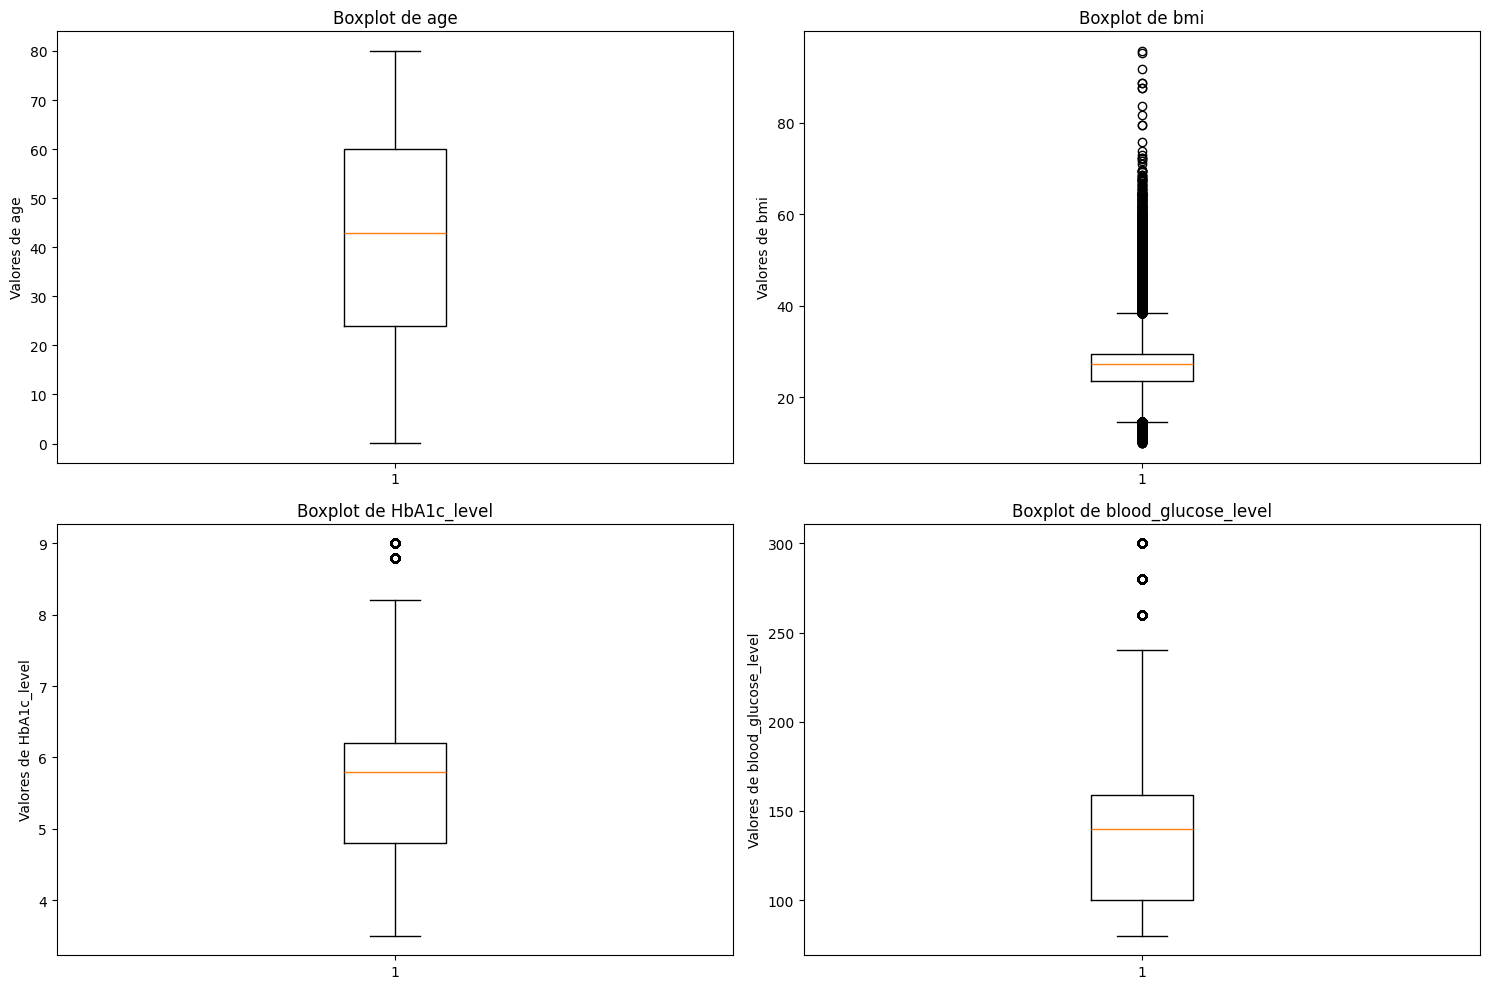

In [ ]:
columnasParaVer = ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']

plt.figure(figsize=(15, 10))

for i, columna in enumerate(columnasParaVer):
    plt.subplot(2, 2, i + 1)
    plt.boxplot(dfOneHot[columna].dropna())
    plt.title(f'Boxplot de {columna}')
    plt.ylabel(f'Valores de {columna}')

plt.tight_layout()
plt.show()

Para el normalizado usamos RobustScaler (explicado en el informe), pero lo haremos "a mano" en lugar de con sklearn:
(Xi-Xmediana) / Xiqr

In [ ]:
dfNormalizado = dfOneHot.copy()

columnasEstandarizables = ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']

for columna in columnasEstandarizables:
    mediana = dfNormalizado[columna].median()
    Q1 = dfNormalizado[columna].quantile(0.25)
    Q3 = dfNormalizado[columna].quantile(0.75)
    IQR = Q3 - Q1

    if IQR == 0:
        dfNormalizado[columna] = 0
    else:
        dfNormalizado[columna] = (dfNormalizado[columna] - mediana) / IQR

print(dfNormalizado[columnasEstandarizables].head())


        age       bmi  HbA1c_level  blood_glucose_level
0  1.027778 -0.357983     0.571429             0.000000
1  0.305556  0.000000     0.571429            -1.016949
2 -0.416667  0.000000    -0.071429             0.305085
3 -0.194444 -0.650420    -0.571429             0.254237
4  0.916667 -1.206723    -0.714286             0.254237


Ya con todo terminado, hacemos el nuevo csv con los datos depurados

In [ ]:
dfNormalizado.to_csv('diabetes_prediccion_normalizado.csv',index=False)